# INFO

Requirements:
- Data files: folders  sevnZ0.001, sevnZ0.0001, sevnZ0.02 containing the sevn outputs at the correspondent metallicities.
    All the folders are already available in repository 
- Python 3.9 or newer
- modules: pandas, numpy, matplotlib, scipy

Auxiliary data:
- listSin.txt: input data used for the SEVN runs
- run_sse.sh: run script used for the SEVN runs

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
label_size =20
plt.rcParams.update({'font.size': label_size})
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
#mpl.rcParams['mathtext.default']='regular'
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['contour.negative_linestyle'] = 'solid'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 1
import warnings
warnings.filterwarnings('ignore')
import subprocess
import warnings
warnings.filterwarnings('ignore')
import subprocess

import matplotlib.colors as colors

In [2]:
from scipy.interpolate import UnivariateSpline as us

class Interpolated_track:
    
    def __init__(self,trackfile,Mzams,Mzams1,Mzams2,intt="rational"):
        
        self.Mzams=Mzams
        self.Mzams1=Mzams1
        self.Mzams2=Mzams2 
        
        self.track1=trackfile[trackfile.Zams==Mzams1]
        self.track1["Worldtime"]=np.cumsum(self.track1.Timestep)
        self.track2=trackfile[trackfile.Zams==Mzams2]
        self.track2["Worldtime"]=np.cumsum(self.track2.Timestep)
        
        self.tinterpolator=None
        if intt=="log": self.tinterpolator=self.interp_log
        elif intt=="lin": self.tinterpolator=self.interp_lin
        elif intt=="rational": self.tinterpolator=self.interp_rational
        
        
        self.set_phases()
        
    def set_phases(self):
        self.tphases={}
        self.tphases1={}
        self.tphases2={}
        
        for phase in range(1,8):
            Tphase1=self.track1[self.track1.Phase==phase]["Worldtime"].min()
            Tphase2=self.track2[self.track2.Phase==phase]["Worldtime"].min()
            self.tphases1[phase]=Tphase1
            self.tphases2[phase]=Tphase2
            self.tphases[phase]=self.tinterpolator(Tphase1,Tphase2)
    
    def evolve_property(self,prop,inttype="lin",pphase=10):
        
        if inttype=="log": finterp=self.interp_log
        elif inttype=="lin": finterp=self.interp_lin
        elif inttype=="rational": finterp=self.interp_rational
        
        f1=us(self.track1["Worldtime"],self.track1[prop],k=1,s=0)
        f2=us(self.track2["Worldtime"],self.track2[prop],k=1,s=0)
        
        plifepoints=np.linspace(0,0.999999,pphase)
        
        ttimes=[]
        props=[]
        for phase in self.tphases:
            
            if phase<7:
                ts=self.tphases[phase]
                te=self.tphases[phase+1]
                ts1=self.tphases1[phase]
                te1=self.tphases1[phase+1]
                ts2=self.tphases2[phase]
                te2=self.tphases2[phase+1]         
                
                times=plifepoints*(te-ts)+ts
                times1=plifepoints*(te1-ts1)+ts1
                times2=plifepoints*(te2-ts2)+ts2
                
                prop_interp=finterp(f1(times1),f2(times2))
                ttimes+=list(times)
                props+=list(prop_interp)

        return np.array(ttimes), np.array(props)
            
            
        
    
    def interp_lin(self,val1,val2):
        DM=self.Mzams2-self.Mzams1
        
        w1=(self.Mzams2-self.Mzams)/DM
        w2=(self.Mzams-self.Mzams1)/DM
        
        
        return w1*val1+w2*val2
    
    def interp_rational(self,val1,val2):
        DM=self.Mzams2-self.Mzams1
        
        w1=(self.Mzams1/self.Mzams)*(self.Mzams2-self.Mzams)/DM
        w2=(self.Mzams2/self.Mzams)*(self.Mzams-self.Mzams1)/DM
        
        return w1*val1+w2*val2
    
    def interp_log(self,val1,val2):
        DM=np.log10(self.Mzams2)-np.log10(self.Mzams1)
        
        w1=(np.log10(self.Mzams2)-np.log10(self.Mzams))/DM
        w2=(np.log10(self.Mzams)-np.log10(self.Mzams1))/DM
        
        ret=w1*np.log10(val1) + w2*np.log10(val2)
        
        return 10**ret


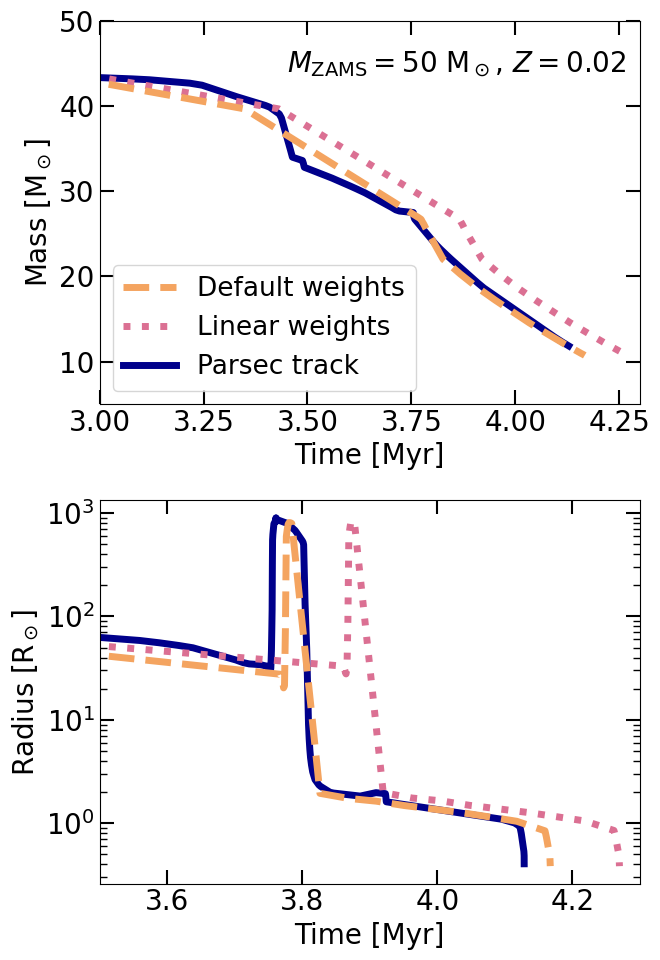

In [11]:
df=pd.read_csv("sevnZ0.02/output_0.csv")
dft=df[(df.Zams==50) & (df.Phase<7)]
frat=Interpolated_track(df,50,40,60,intt="rational")
lrat=Interpolated_track(df,50,40,60,intt="lin")

alpha_c={5:"sandybrown", 3:"palevioletred", 1:"blueviolet", 0.5:"darkblue"}



fig,axl=plt.subplots(2,1,figsize=(7,10))

ax=axl[0]

tf,Mf=frat.evolve_property("Mass","lin")
tl,Ml=lrat.evolve_property("Mass","lin")
tlo,Mlo=lrat.evolve_property("Mass","log")

ax.plot(tf,Mf,label="Default weights",lw=5,ls="dashed",color="sandybrown",zorder=10000)
ax.plot(tl,Ml,label="Linear weights",lw=5,ls="dotted",color="palevioletred",zorder=1000)
ax.plot(dft.Worldtime,dft.Mass,lw=5,color="darkblue",label="Parsec track")
ax.set_xlim(3,4.3)
ax.set_ylim(5,50)
ax.set_ylabel("Mass [M$_\odot$]")
ax.set_xlabel("Time [Myr]")
ax.legend(loc="lower left",fontsize=label_size-1)
ax.tick_params(axis='both', which='both',direction="in",top="on",right="on")
ax.text(3.45,44,"$M_\mathrm{ZAMS}=50 \ \mathrm{M}_\odot$, $Z=0.02$")

ax=axl[1]

tf,Mf=frat.evolve_property("Radius","log")
tl,Ml=lrat.evolve_property("Radius","lin")

ax.plot(tf,Mf,label="Default weights",lw=5,ls="dashed",color="sandybrown",zorder=10000)
ax.plot(tl,Ml,label="Linear weights",lw=5,ls="dotted",color="palevioletred",zorder=1000)
ax.plot(dft.Worldtime,dft.Radius,lw=5,color="darkblue",label="Parsec track")
ax.set_xlim(3.5,4.3)
#ax.set_ylim(5,50)
ax.set_ylabel("Radius [R$_\odot$]")
ax.set_xlabel("Time [Myr]")
#ax.legend(loc="lower left",fontsize=label_size-1)
ax.set_yscale("log")
ax.tick_params(axis='both', which='both',direction="in",top="on",right="on")

fig.savefig("interp_test.pdf")